This script calculates an airfoil and outputs it to a format to be read by gmsh works for gmsh 4.7.1

In [1]:
#import common modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# import fish utility modules
import airfoil as ar

from scipy import optimize

First we specify the thickness and chord length and then call the naca4 function in `airfoil.py`.  The format for that function is naca4(x_coordinates, thickness, camber, location of max thickness, closed trailing edge, chord length)  

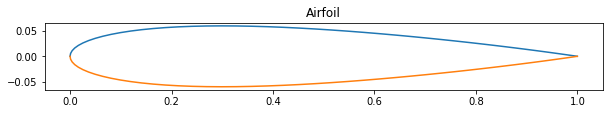

In [2]:
# half-cosine spacing
coord_points = 50   # number of points for upper and lower surface
beta = np.linspace(0, np.pi, coord_points)
dx = (0.5*(1-np.cos(beta)))
# uniform spacing
#dx = np.linspace(0.0, chord, 200)

chord = 1.0   # chord
t = 0.12   # thickness
m = 0.0    # camber
p = 0.3    # location of maximum camber
TE = True  # trailing edge closed

# call the functoin
x, y = ar.naca4(dx, t, m, p, TE, chord)

#convert coordinates to upper and lower arrays
xu = x[0]
xl = x[1]
yu = y[0]
yl = y[1]

# plot the results
f1, ax1 = plt.subplots(figsize=(10,20))
ax1.plot(xu, yu)
ax1.plot(xl, yl)
ax1.set_title('Airfoil')
ax1.set_aspect('equal')

Write to a .geo file

In [3]:
# Create array for writing
bLength = 2

point = np.zeros((2*coord_points-2,3))
point2 = np.zeros((2*coord_points-2,3))
ind = 0

point[0:coord_points, 0] = xu
point[0:coord_points, 1] = yu
point[0:coord_points, 2] = 0.0

point2[0:coord_points, 0] = (xu * bLength - (xu[-1]*0.33))
point2[0:coord_points, 1] = yu * bLength
point2[0:coord_points, 2] = 0.0

point[coord_points:, 0] = np.flipud(xl[1:-1])
point[coord_points:, 1] = np.flipud(yl[1:-1])
point[coord_points:, 2] = 0.0

point2[coord_points:, 0] = (np.flipud(xl[1:-1]) * bLength - (xl[-1]*0.33))
point2[coord_points:, 1] = np.flipud(yl[1:-1]) * bLength
point2[coord_points:, 2] = 0.0

num_points = point.shape[0]
bl_points = point2.shape[0]

airfoil_point_index = np.arange(1, point.shape[0]+1)
airfoil_bl_point_index = np.arange(airfoil_point_index[-1]+1, airfoil_point_index[-1]+1+point2.shape[0])

We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil

No we should calculate the y+ value and all our boundary layer values

Credit to https://www.fluidmechanics101.com/pdf/calculators.pdf

For the calculation processes

In [4]:
# Define our setup variables
U = 1.0                                 # Freestream Velocity
L = 1.0                                 # Length            
density = 1025                          # fluid density
kinVisc = 2.5e-11                       # kinematic viscosity of fluid
dynamicVisc = density * kinVisc         # dynamic viscosity of fluid
yPlus = 5.0                             # desired Y+
growth_ratio = 1.1                      # growth ratio
N = 20                                  # number of inflation layers

# calculate the Reynolds Number
Re = U * L / kinVisc

# calculate the skin friction coefficient
Cf = (2*np.log10(Re) - 0.65)**(-2.3)

# calculate the shear wall stress
tw = 0.5 * density * U**2 * Cf

# calculate the friction velocity
ut = np.sqrt(tw / density)

# calculate yp where yp is the distance to the centroid of the first cell
# based on desired y+. yH is the first cell height which is 2 times the centroid
yp =  (yPlus * dynamicVisc) / (ut * density)

yH = 2 * yp

# Estimate the boundary layer thickness using the Blasius solution
# laminar and turbulent are given here
if ( Re < 4e5):
    delta = 4.91 * L / np.sqrt(Re)
else:
    delta = 0.38 * L / Re**(1/5)

# calculate the total thickness of the inflation layers yT
# specify the growth ratio
yT = yH * ((1 - growth_ratio**N)/(1 - growth_ratio))

#f = lambda r: (1.14e-8 * ((1 - r**20)/(1 - r)) - 0.00288)

#growth_ratio_calc = optimize.fsolve(f, 1.1)
# Give the final layer thickness
yFinal = yH * growth_ratio**(N - 1)

We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil

In [5]:
airfoil_cl = 0.005
bl_cl = 0.005

hfar = 0.01
hwall_n = 0.0005
thickness = 0.02

In [6]:
#Write data to the .geo file
with open('airfoil_small_bl.geo', 'w') as df:
    # first we write the variables for easy changing locally later
    df.write('airfoil_cl = %f;\n' % (airfoil_cl))
    df.write('bl_cl = %f;\n' % (bl_cl))
    df.write('\n')

    for i, index in zip(np.arange(0, point.shape[0], 1), airfoil_point_index):
        df.write('Point(%i) = {%f, %f, %f, airfoil_cl};\n' % (index, point[i,0], point[i,1],
                                                    point[i,2]))
    point_index = i
    df.write('\n')

    for i, index in zip(np.arange(0, point2.shape[0], 1), airfoil_bl_point_index):
        df.write('Point(%i) = {%f, %f, %f, bl_cl};\n' % (index, point2[i,0], point2[i,1],
                                                    point2[i,2]))
        point_index += 1
    df.write('\n')
    
    line_loops = np.array([101, 102])
    plane_surface = np.array([201])
    # write the boundary domain points
    df.write('// combine foil points into a bspline \n')
    df.write('BSpline(5) = {'  + str(airfoil_point_index[0]) + ':' + str(airfoil_point_index[int(airfoil_point_index.shape[0]/2)]) + '}; \n')
    df.write('BSpline(6) = {' + str(airfoil_point_index[int(airfoil_point_index.shape[0]/2)]) + ':' + str(airfoil_point_index[-1]) + ',' +  str(airfoil_point_index[0]) + '}; \n')
    df.write('Line Loop(' + str(line_loops[0]) + ') = {5, 6}; \n') 
    df.write('\n')
       
    df.write('\n')
    df.write('// combine foil points into a bspline \n')
    df.write('BSpline(7) = {'  + str(airfoil_bl_point_index[0]) + ':' + str(airfoil_bl_point_index[int(airfoil_bl_point_index.shape[0]/2)]) + '}; \n')
    df.write('BSpline(8) = {' + str(airfoil_bl_point_index[int(airfoil_bl_point_index.shape[0]/2)]) + ':' + str(airfoil_bl_point_index[-1]) + ',' +  str(airfoil_bl_point_index[0]) + '}; \n')
    df.write('Line Loop(' + str(line_loops[1]) + ') = {7, 8}; \n') 
    df.write('\n')
   
    # df.write('Plane Surface(' + str(plane_surface[0]) + ') = {101, 102}; \n')
    
    # df.write('\n')
    # # extrude the surface so we can name the boundaries
    # df.write('Extrude {0, 0, 1} {\n Surface{' + str(plane_surface[0]) + '};\n Layers{1};\n Recombine;\n}')
    # df.write('\n')
    # define the boundary layer addition
    # df.write('//Define the boundary layer \n')
    # df.write('Field[1] = BoundaryLayer; \n')
    # df.write('Field[1].EdgesList = {5, 6}; \n')
    # df.write('Field[1].NodesList = {1, 1021, 1022, ' + str(airfoil_point_numbers[-1]) + '}; \n')
    # df.write('Field[1].hfar = ' + str(hfar) + '; \n')
    # df.write('Field[1].hwall_n = ' + str(hwall_n) + '; \n')
    # df.write('Field[1].thickness = ' + str(thickness) + '; \n')
    # df.write('Field[1].ratio = ' + str(growth_ratio) + '; \n')
    # df.write('Field[1].AnisoMax = 10; \n')
    # df.write('Field[1].Quads = 1; \n')
    # df.write('Field[1].IntersectMetrics = 0; \n')
    # df.write('BoundaryLayer Field = 1; \n')

In [7]:
airfoil_point_index

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [8]:
airfoil_bl_point_index

array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196])